# UKG to CMiC Integration Middleware
This python project pulls time entry data from UKG Time Management (UTM) along with associated employee information, transforms it into the necessary format for upload to CMiC pytimesheets, and posts the entries. Check log files for errors.

In [1]:
import pandas as pd
from datetime import datetime
from pay_period import find_period_by_date,payRuntoPayGroup

selectionDate = datetime(2025,10,3)
#B or W for biweekly or weekly payruns
payRun = 'W'
PAYGROUPID = payRuntoPayGroup[payRun]
pay_period_file = "DataFiles/Pay_Period.csv"
df = pd.read_csv(pay_period_file, skiprows=2)
period_df = find_period_by_date(df,payRun,selectionDate)
period_df

,Period,Start Date,End Date,Process Date,Posting Date,Pay Date,Month,Posted Flag,Close Etimesheet Period,Pay Run
65,40,2025-09-28,2025-10-04,2025-10-04,2025-10-04,2025-10-04,10,N,N,W


In [2]:
startdate = period_df['Start Date'].iloc[0]
enddate = period_df['End Date'].iloc[0]
print(f"{startdate=}, {enddate=}, {payRun=}, {PAYGROUPID=}")

startdate=Timestamp('2025-09-28 00:00:00'), enddate=Timestamp('2025-10-04 00:00:00'), payRun='W', PAYGROUPID=43


In [3]:
import utm_load
utm_load.load_ukg(startdate, enddate, PAYGROUPID)

from cmic import load_cmic_projects
load_cmic_projects()

2025-10-16 11:22:19,090 | INFO | utm_load | trying OrgLevel1...
2025-10-16 11:22:19,090 | INFO | utm_load | trying OrgLevel1...
2025-10-16 11:22:19,621 | INFO | utm_load | record counts for OrgLevel1:298
2025-10-16 11:22:19,621 | INFO | utm_load | record counts for OrgLevel1:298
2025-10-16 11:22:19,623 | INFO | utm_load | trying OrgLevel2...
2025-10-16 11:22:19,623 | INFO | utm_load | trying OrgLevel2...
2025-10-16 11:22:19,935 | INFO | utm_load | record counts for OrgLevel2:598
2025-10-16 11:22:19,935 | INFO | utm_load | record counts for OrgLevel2:598
2025-10-16 11:22:19,937 | INFO | utm_load | trying OrgLevel3...
2025-10-16 11:22:19,937 | INFO | utm_load | trying OrgLevel3...
2025-10-16 11:22:20,070 | INFO | utm_load | record counts for OrgLevel3:149
2025-10-16 11:22:20,070 | INFO | utm_load | record counts for OrgLevel3:149
2025-10-16 11:22:20,072 | INFO | utm_load | trying OrgLevel4...
2025-10-16 11:22:20,072 | INFO | utm_load | trying OrgLevel4...
2025-10-16 11:22:20,180 | INFO |

In [4]:
from cmic import employee_push
startdate_str = startdate.strftime("%Y-%m-%d")
employee_push(startdate_str)

2025-10-16 11:25:59,274 | INFO | cmic.CMiCAPIClient | creating instance of CMiCAPIClient
2025-10-16 11:25:59,283 | INFO | cmic | requestion records from hcm-rest-api/rest/1/pytrades?fields=TrdCode with limit=500
2025-10-16 11:25:59,286 | INFO | cmic | Requesting offset=0...
2025-10-16 11:25:59,427 | INFO | cmic | Retrieved 153 records — has_more=False
2025-10-16 11:25:59,429 | INFO | cmic | No more pages. Loaded 153 items
2025-10-16 11:25:59,442 | INFO | cmic | Found 5 matching employees. Starting POSTs...

2025-10-16 11:25:59,445 | INFO | cmic | requestion records from hcm-rest-api/rest/1/pyemployee?fields=EmpChargeOutRate,EmpNo with limit=500
2025-10-16 11:25:59,447 | INFO | cmic | Requesting offset=0...
2025-10-16 11:26:01,344 | INFO | cmic | Retrieved 276 records — has_more=False
2025-10-16 11:26:01,345 | INFO | cmic | No more pages. Loaded 276 items
2025-10-16 11:26:01,354 | INFO | cmic | writing 0 records to file


In [5]:
from cmic import post_timesheets_to_CMiC
import pandas as pd
import matplotlib as mpl
df_timesheet_post_results = post_timesheets_to_CMiC('B',testing=True)

2025-10-16 11:27:03,035 | INFO | cmic.CMiCAPIClient | creating instance of CMiCAPIClient
2025-10-16 11:27:07,933 | INFO | cmic | Post log written to DataFiles/PostResult/PostResults_10162025_112707.csv


In [6]:
df_timesheet_post_results.describe(include='all')

,EmpNo,WorkDate,PrnCode,Status,Response,Hours,SourceFile
count,25.000000,25,25,25.0,25,25.0,25
unique,NaN,5,1,NaN,1,NaN,1
top,NaN,2025-09-29,W,NaN,{ },NaN,PostResults_10162025_112707.csv
freq,NaN,5,25,NaN,25,NaN,25
mean,223576.800000,NaN,NaN,201.0,NaN,8.0,NaN
std,25.847308,NaN,NaN,0.0,NaN,0.0,NaN
min,223543.000000,NaN,NaN,201.0,NaN,8.0,NaN
25%,223550.000000,NaN,NaN,201.0,NaN,8.0,NaN
50%,223588.000000,NaN,NaN,201.0,NaN,8.0,NaN
75%,223601.000000,NaN,NaN,201.0,NaN,8.0,NaN


In [ ]:
#since PostResults can contain multiple retries, filter to only most recent attempt
filtered_post_results = df_timesheet_post_results.groupby(['EmpNo','WorkDate'])['Status'].idxmax()
df_filtered_post_results = df_timesheet_post_results.loc[filtered_post_results]

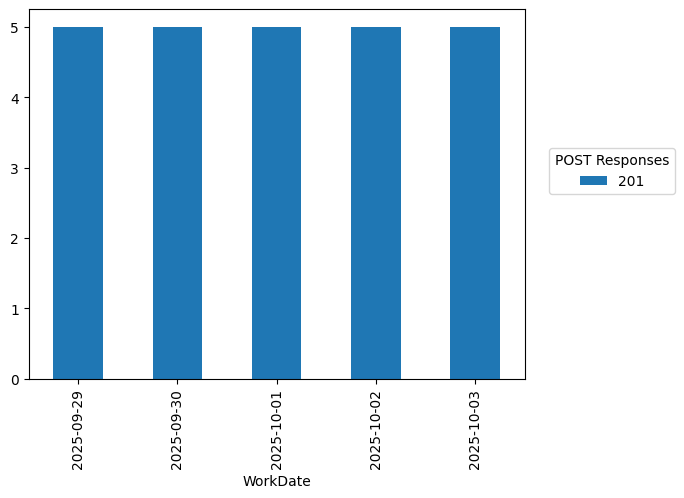

In [9]:
plot_data = df_filtered_post_results.pivot_table(index='WorkDate',columns='Status',values='Hours',aggfunc='count')
chart = plot_data.plot(kind='bar')\
        .legend(loc=(1.05,0.5))\
        .set_title('POST Responses')
chart

In [10]:
df_filtered_post_results.loc[df_timesheet_post_results["Status"]=="400"]

,EmpNo,WorkDate,PrnCode,Status,Response,Hours,SourceFile


In [11]:
df_filtered_post_results.loc[df_timesheet_post_results["Status"]==201].count()

EmpNo         25
WorkDate      25
PrnCode       25
Status        25
Response      25
Hours         25
SourceFile    25
dtype: int64